In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from scipy.ndimage import generic_filter
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import os
import warnings
import gstools
from collections import deque
from skimage.filters.rank import modal
from skimage.morphology import disk
from skimage.util import img_as_ubyte
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")
import random
from PIL import Image
from scipy.ndimage import center_of_mass
from scipy.spatial.distance import cdist
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from scipy import stats
from scipy.optimize import linear_sum_assignment
from scipy.stats import entropy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from guided_filter_pytorch.guided_filter import GuidedFilter
from scipy.stats import norm
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, v_measure_score
from scipy.ndimage import convolve
import pickle

# Gaussians components Generation

In [11]:
rng = np.random.default_rng(0)
shape = (100, 100)
#  Gaussian parameters
means = [12, 15, 19, 23, 26]
stds = [2, 1.5,1.25, 1.75,2 ]

# Generation of Gaussian matrices
gaussian_matrices = []
for mean, std in zip(means, stds):
    mat = rng.normal(loc=mean, scale=std, size=shape)
    gaussian_matrices.append(mat)

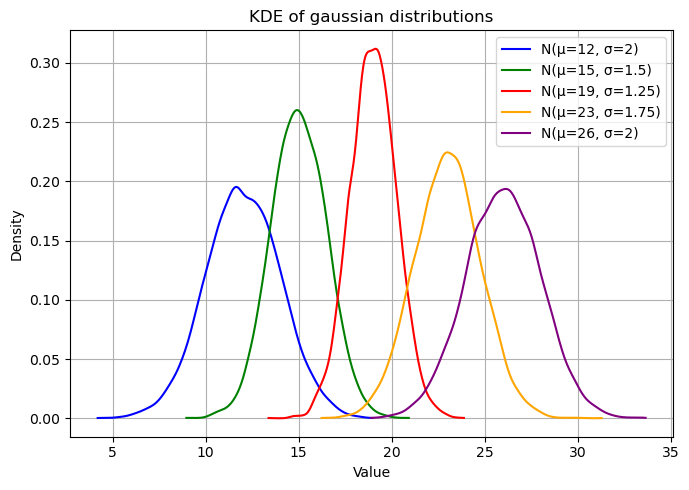

In [12]:
colors = ['blue', 'green', 'red', 'orange', 'purple']
labels = [f"N(μ={mean}, σ={std})" for mean, std in zip(means, stds)]

plt.figure(figsize=(7, 5))

for i, (mat, color, label) in enumerate(zip(gaussian_matrices, colors, labels)):
    data = mat.ravel()
    kde = stats.gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 300)
    y_vals = kde(x_vals)
    plt.plot(x_vals, y_vals, color=color, label=label)

# Mise en forme du graphique
plt.title("KDE of gaussian distributions")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Simple Synthetic Datesets

### SD1

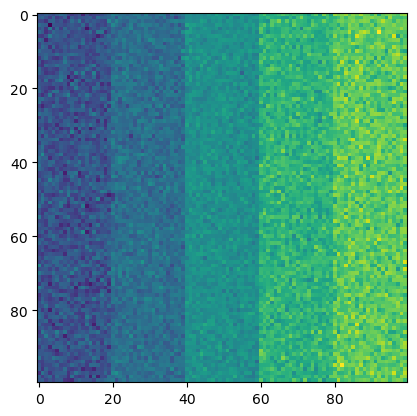

In [8]:
sd1 = np.zeros(shape)
label_sd1 = np.full(shape, -1)

for i in range(5):
    col_start = i * 20
    col_end = col_start + 20
    sd1[:, col_start:col_end] = gaussian_matrices[i][:, col_start:col_end]
    label_sd1[:, col_start:col_end] = i

plt.imshow(sd1)

### SD2

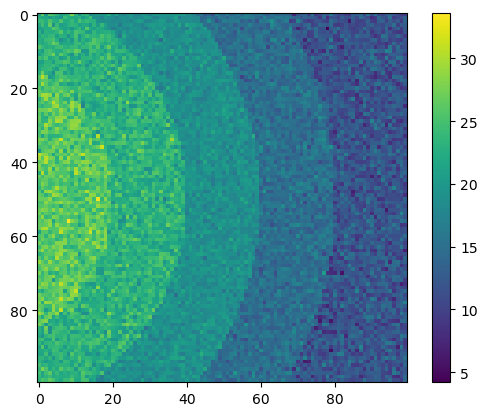

In [9]:
sd2 = gaussian_matrices[0].copy()
label_sd2 = np.zeros(shape, dtype=int)  

# Centre of circles (x, y)
center_x = 50
center_y = -20


# Decreasing radii and correspondence between classes 1 to 4
radii = [100, 80, 60, 40]
for i, radius in enumerate(radii):
    label = i + 1
    source_matrix = gaussian_matrices[label]
    
    for x in range(shape[0]):
        for y in range(shape[0]):
            distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
            if distance < radius:
                sd2[x, y] = source_matrix[x, y]
                label_sd2[x, y] = label

c = plt.imshow(sd2)
plt.colorbar(c)

# Geological Synthetic Dataset 

In [13]:
def smooth_labels(label_matrix, radius=5):
    label_uint8 = label_matrix.astype(np.uint8)
    return modal(label_uint8, disk(radius))
    
def reorder_labels_by_spatial_proximity(label_matrix, n_labels=5):
    new_label_matrix = np.zeros_like(label_matrix)

    # 1. Trouver les centres de chaque cluster
    centers = np.array([center_of_mass(label_matrix == i) for i in range(n_labels)])

    # 2. Déterminer l'ordre spatial via plus proche voisin
    remaining = list(range(n_labels))
    ordered_labels = []
    current = remaining.pop(0)
    ordered_labels.append(current)

    while remaining:
        distances = cdist([centers[current]], centers[remaining])
        closest_idx = np.argmin(distances)
        current = remaining.pop(closest_idx)
        ordered_labels.append(current)

    # 3. Créer un mapping : ancien label → nouveau label
    label_mapping = {old: new for new, old in enumerate(ordered_labels)}

    # 4. Appliquer le mapping
    for old_label, new_label in label_mapping.items():
        new_label_matrix[label_matrix == old_label] = new_label

    return new_label_matrix

In [14]:
base_path = "img_form_sup/format_sup_"
image_files = ["1.png", "2.png", "3.png", "4.png"]

datasets_gds = []
label_matrices = []

for fname in image_files:
    path = base_path + fname
    image = Image.open(path)


    image_resized = image.resize(shape)
    img = np.asarray(image_resized.convert("RGB"))

    # Pixels imgae Clustering KMeans 
    pixels = img.reshape(-1, 3)
    kmeans = KMeans(n_clusters=5, random_state=42)
    labels = kmeans.fit_predict(pixels)
    

    # Label matrix
    label_matrix = labels.reshape(shape)
    label_matrix = reorder_labels_by_spatial_proximity(smooth_labels(label_matrix,radius=5),5)
    label_matrices.append(label_matrix)
    

    # Générer les valeurs gaussiennes en fonction des labels
    dataset = np.zeros(shape)
    for label in range(5):
        mask = (label_matrix == label)
        dataset[mask] = rng.normal(loc=means[label], scale=stds[label], size=np.sum(mask))
    datasets_gds.append(dataset)

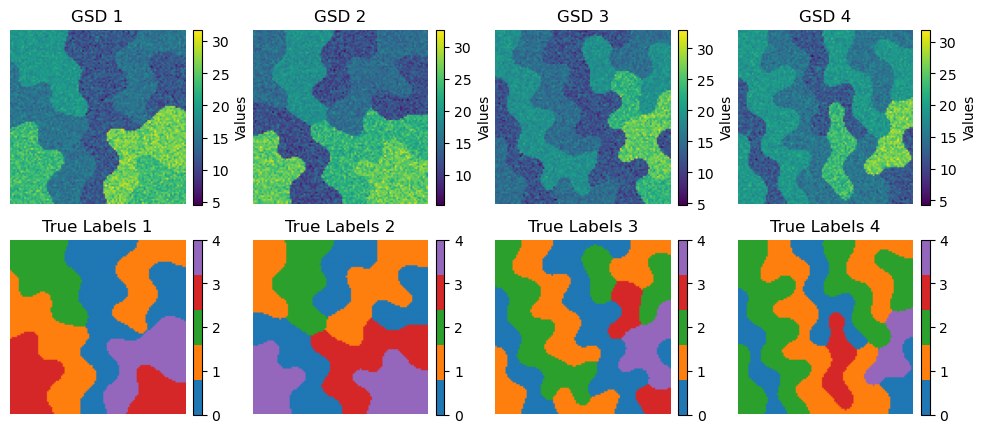

In [15]:
cmap_tab5 = ListedColormap(plt.get_cmap("tab10").colors[:5])

fig, axes = plt.subplots(2, 4, figsize=(12, 5))

for i in range(len(datasets_gds)):
    # Dataset simulé (à gauche)
    im = axes[0, i].imshow(datasets_gds[i], cmap='viridis')
    axes[0, i].set_title(f"GSD {i+1}")
    axes[0, i].axis('off')
    cbar = fig.colorbar(im, ax=axes[0, i], fraction=0.046, pad=0.04)
    cbar.set_label("Values")

    # Labels (à droite) avec cmap limité à 5 classes
    im_labels = axes[1, i].imshow(label_matrices[i], cmap=cmap_tab5, vmin=0, vmax=4)
    axes[1, i].set_title(f"True Labels {i+1}")
    axes[1, i].axis('off')

    # Colorbar explicite : ticks de 0 à 4 uniquement
    cbar_labels = fig.colorbar(im_labels, ax=axes[1, i], ticks=[0, 1, 2, 3, 4], fraction=0.046, pad=0.04)
   
#plt.savefig('fig/gsd.png',dpi=300,bbox_inches='tight')
plt.show()


# [Zhou et al 2020] spatial aided GMM SAGMM

In [18]:
class SpatiallyAidedGMM:
    def __init__(self, n_clusters=2, n_spatial_components=2, max_iter=100):
        self.n_clusters = n_clusters
        self.n_spatial_components = n_spatial_components
        self.max_iter = max_iter
        self.gmm_feature = GaussianMixture(n_components=n_clusters, max_iter=max_iter)
        self.gmm_spatial = [GaussianMixture(n_components=n_spatial_components, max_iter=max_iter) for _ in range(n_clusters)]

    def fit(self, X, S):
        """
        X: Feature matrix (kinematic data) of shape (M, D)
        S: Spatial coordinates of shape (M, 2)
        """
        # Step 1: Fit GMM on kinematic features
        self.gmm_feature.fit(X)
        cluster_assignments = self.gmm_feature.predict(X)
        
        # Step 2: Fit spatial GMM for each cluster
        for k in range(self.n_clusters):
            cluster_indices = np.where(cluster_assignments == k)[0]
            if len(cluster_indices) > self.n_spatial_components:
                self.gmm_spatial[k].fit(S[cluster_indices])
            else:
                self.gmm_spatial[k] = None  # Avoid fitting on very few points
        
    def predict_proba(self, X, S):
        """
        Compute the probability of each point belonging to a cluster.
        """
        feature_probs = self.gmm_feature.predict_proba(X)
        spatial_probs = np.zeros_like(feature_probs)
        
        for k in range(self.n_clusters):
            if self.gmm_spatial[k] is not None:
                spatial_probs[:, k] = np.exp(self.gmm_spatial[k].score_samples(S))
        
        # Normalize spatial probabilities
        spatial_probs /= spatial_probs.sum(axis=1, keepdims=True) + 1e-10
        
        # Compute final probability as the product of feature and spatial probabilities
        final_probs = feature_probs * spatial_probs
        final_probs /= final_probs.sum(axis=1, keepdims=True) + 1e-10
        return final_probs
    
    def predict(self, X, S):
        """
        Assign each point to the most probable cluster.
        """
        return np.argmax(self.predict_proba(X, S), axis=1)

# [Zao et al 2016] Spatial GMM SGMM

In [189]:
def extract_sliding_windows(image, window_size=3):
    pad = window_size // 2
    padded_image = np.pad(image, pad, mode='edge')
    windows = []
    centers = []
    for i in range(pad, pad + image.shape[0]):
        for j in range(pad, pad + image.shape[1]):
            window = padded_image[i-pad:i+pad+1, j-pad:j+pad+1].flatten()
            windows.append(window)
            centers.append((i-pad, j-pad))
    return np.array(windows), centers
def sgmm(image, K=3, window_size=3, max_iter=10, tol=1e-4,random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    windows, centers = extract_sliding_windows(image, window_size)
    M, N = windows.shape
    D = 1  # grayscale


    flat_pixels = image.reshape(-1, 1)
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=random_state).fit(flat_pixels)
    
    # Initial mean µ_k from kmeans centers
    mu = kmeans.cluster_centers_.flatten()
    
    
    sigma2 = np.zeros((K, 1))
    #labels = kmeans.labels_.reshape(image.shape)
    for k in range(K):
        pixels_in_k = flat_pixels[kmeans.labels_ == k]
        sigma2[k, 0] = np.var(pixels_in_k) + 1e-4 
    alpha = np.ones((M, K)) / K
    rng = np.random.RandomState(random_state)
    tau = rng.dirichlet(np.ones(K), (M, N))
    L_prev = None
    grad_L = 1
    t = 0
    
    while grad_L > tol and t < max_iter:
        # --- M-step ---
        for k in range(K):
            numerator = np.sum(tau[:, :, k] * windows)
            denominator = np.sum(tau[:, :, k])
            mu[k] = numerator / (denominator + 1e-12)

            sigma2[k, 0] = np.sum(tau[:, :, k] * (windows - mu[k])**2) / (denominator + 1e-12)

        alpha = np.sum(tau, axis=1) / N

        # --- E-step ---
        pdfs = np.zeros((M, N, K))
        for k in range(K):
            pdfs[:, :, k] = norm.pdf(windows, mu[k], np.sqrt(sigma2[k, 0]))
        weighted_pdfs = alpha[:, np.newaxis, :] * pdfs
        denominator = np.sum(weighted_pdfs, axis=2, keepdims=True) + 1e-12
        tau = weighted_pdfs / denominator

        # --- Log-likelihood ---
        L_new = 0
        L_new = np.sum(np.log(np.sum(weighted_pdfs, axis=2) + 1e-12)) / N
    

        # --- Verbosity ---
        if L_prev is not None:
            grad_L = np.abs(L_prev - L_new) / (np.abs(L_prev) + 1e-12)
        else:
            grad_L = np.inf

        # print(f"Iter {t:02d} | LogL = {L_new:.5f} | ∇L = {grad_L:.5e}",end="/")
        # print(f"   μ: {mu}")
        # print(f"   σ²: {sigma2.flatten()}")

        L_prev = L_new
        label_image = np.zeros_like(image, dtype=int)
        labels = np.argmax(alpha, axis=1)
        for idx, (i, j) in enumerate(centers):
            label_image[i, j] = labels[idx]
        t += 1

    return label_image, mu, sigma2,alpha

# KB-SGMM

In [17]:
def gaussian_kernel(size, sigma=1.0):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    return kernel / np.sum(kernel)


def kb_sgmm(dataset, gmm_model, lambda_=0.0, window_size=6):
    h, w = dataset.shape
    X_val = dataset.reshape(-1, 1)
    
    # GMM shape probabilities (h * w, n_classes)
    probs = gmm_model.predict_proba(X_val)
    probs_2d = probs.reshape(h, w, -1)

    # kernel = np.ones((window_size, window_size), dtype=np.float32) / (window_size ** 2)
    kernel = gaussian_kernel(window_size, sigma=window_size / 3)
    
    smoothed = np.stack([
        convolve(probs_2d[:, :, i], kernel, mode='constant')
        for i in range(probs_2d.shape[-1])
    ], axis=-1)

    corrected = lambda_ * probs_2d + (1 - lambda_) * smoothed

    corrected /= corrected.sum(axis=-1, keepdims=True)

    return np.argmax(corrected, axis=-1),corrected,probs_2d


In [61]:
def evaluate_clustering(true_labels, pred_labels):
    true_labels, pred_labels = true_labels.flatten(),pred_labels.flatten()
    return {
        "ARI": round(adjusted_rand_score(true_labels, pred_labels),2),
        "NMI": round(normalized_mutual_info_score(true_labels, pred_labels),2)
    }

In [62]:
def plot_clustering_results_list(d_name,results_list, h, w, methods=None, cmap='tab10'):
    """
    Plot clustering results from multiple datasets in a grid (1 row per dataset).

    Parameters:
    - results_list: list of dicts, each with keys as method names and values as label arrays
    - h, w: height and width to reshape the label arrays into images
    - methods: list of methods to include (optional)
    - cmap: colormap to use
    """

    n_datasets = len(results_list)

    # Determine all methods if not provided
    if methods is None:
        methods = list(results_list[0].keys())

    n_methods = len(methods)
    fig, axes = plt.subplots(nrows=n_datasets, ncols=n_methods, figsize=(4 * n_methods, 4 * n_datasets))

    # Ensure axes is 2D even if there's only one row or one column
    if n_datasets == 1:
        axes = np.expand_dims(axes, 0)
    if n_methods == 1:
        axes = np.expand_dims(axes, 1)

    for row_idx, results in enumerate(results_list):
        for col_idx, method in enumerate(methods):
            ax = axes[row_idx, col_idx]
            img = results[method].reshape(h, w)
            im = ax.imshow(img, cmap=cmap, vmin=0, vmax=np.max(img))
            ax.set_title(d_name+f"{row_idx+1} - {method}")
            ax.axis('off')

    plt.tight_layout()
    plt.savefig('clustering_'+d_name+'.png',dpi=300,bbox_inches='tight')
    plt.show()

In [63]:
def correct_clustering_labels(true_labels, predicted_labels):
    true_labels = np.asarray(true_labels)
    predicted_labels = np.asarray(predicted_labels)

    cm = confusion_matrix(true_labels, predicted_labels)

    # Hungarian algorithm to maximize correct label matching
    row_ind, col_ind = linear_sum_assignment(-cm)

    label_mapping = {col: row for row, col in zip(row_ind, col_ind)}
    
    corrected_labels = np.array([label_mapping[label] for label in predicted_labels])

    return corrected_labels

In [200]:
def run_clustering_pipeline(X, S, true_labels, n_clusters=3,
                            window_size=6, lambda_=0.3,
                            sgmm_max_iter=40, sgmm_tol=1e-6,
                            random_state=0):
    results = {}
    probas = {}
    h = w = int(np.sqrt(len(X)))
    dataset_reshaped = X.reshape(h, w)
    results['True_labels'] = true_labels.flatten()
    # --- KMEANS ---
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X)
    results["KMeans"] = correct_clustering_labels(true_labels.flatten(),kmeans.labels_)

    # --- GMM classique ---
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=random_state,tol=1e-5).fit(X)
    results["GMM"] =  correct_clustering_labels(true_labels.flatten(),gmm.predict(X))
    

    # --- Spatially Aided GMM ---
    sagmm = SpatiallyAidedGMM(n_clusters=n_clusters)
    sagmm.fit(X, S)
    results["SAGMM"] =  correct_clustering_labels(true_labels.flatten(),sagmm.predict(X, S))
    

    # --- SGMM ---
    labels_sgmm, mu_sgmm, sigma2_sgmm, probs_sgmm = sgmm(
        image=dataset_reshaped,
        K=n_clusters,
        window_size=window_size,
        max_iter=sgmm_max_iter,
        tol=sgmm_tol,
        random_state=random_state
    )
    results["SGMM"] =  correct_clustering_labels(true_labels.flatten(),labels_sgmm.flatten())
    # results["SGMM"] =  labels_sgmm.flatten()
    probas["SGMM"] = probs_sgmm
    # --- KB-SGMM (spatial smoothing) ---
    
    labels_kb, prob_kb, prob_gmm = kb_sgmm(dataset_reshaped, gmm, lambda_=lambda_, window_size=window_size)
    results["KB-SGMM"] =  correct_clustering_labels(true_labels.flatten(),labels_kb.flatten())
    # results["KB-SGMM"] =  labels_kb.flatten()
    probas["KB-SGMM"] = prob_kb.reshape(-1, n_clusters)
    probas["GMM"] = prob_gmm.reshape(-1, n_clusters)
   

    # --- Évaluation ---
    scores = {method: evaluate_clustering(true_labels, pred) for method, pred in results.items()}

    return results, scores, probas


In [65]:
X_indices = np.array([(i, j) for i in range(shape[0]) for j in range(shape[1])])

In [66]:
label_sd1.shape

(100, 100)

In [201]:
# Exemple avec sd1
X1 = sd1.reshape(-1, 1)
S1 = X_indices.reshape(-1, 2)  # coordonnées spatiales (si disponibles)
results1, scores1,proba1, = run_clustering_pipeline(X1, S1, label_sd1, n_clusters=5, window_size=7, lambda_=0.)

# Exemple avec sd2
X2 = sd2.reshape(-1, 1)
results2, scores2, proba2 = run_clustering_pipeline(X2, S1, label_sd2, n_clusters=5,window_size=7, lambda_=0.)


In [202]:
scores1

{'True_labels': {'ARI': 1.0, 'NMI': 1.0},
 'KMeans': {'ARI': 0.55, 'NMI': 0.62},
 'GMM': {'ARI': 0.54, 'NMI': 0.62},
 'SAGMM': {'ARI': 0.72, 'NMI': 0.76},
 'SGMM': {'ARI': 0.97, 'NMI': 0.96},
 'KB-SGMM': {'ARI': 0.94, 'NMI': 0.94}}

In [203]:
scores2

{'True_labels': {'ARI': 1.0, 'NMI': 1.0},
 'KMeans': {'ARI': 0.55, 'NMI': 0.61},
 'GMM': {'ARI': 0.54, 'NMI': 0.61},
 'SAGMM': {'ARI': 0.72, 'NMI': 0.75},
 'SGMM': {'ARI': 0.82, 'NMI': 0.86},
 'KB-SGMM': {'ARI': 0.93, 'NMI': 0.92}}

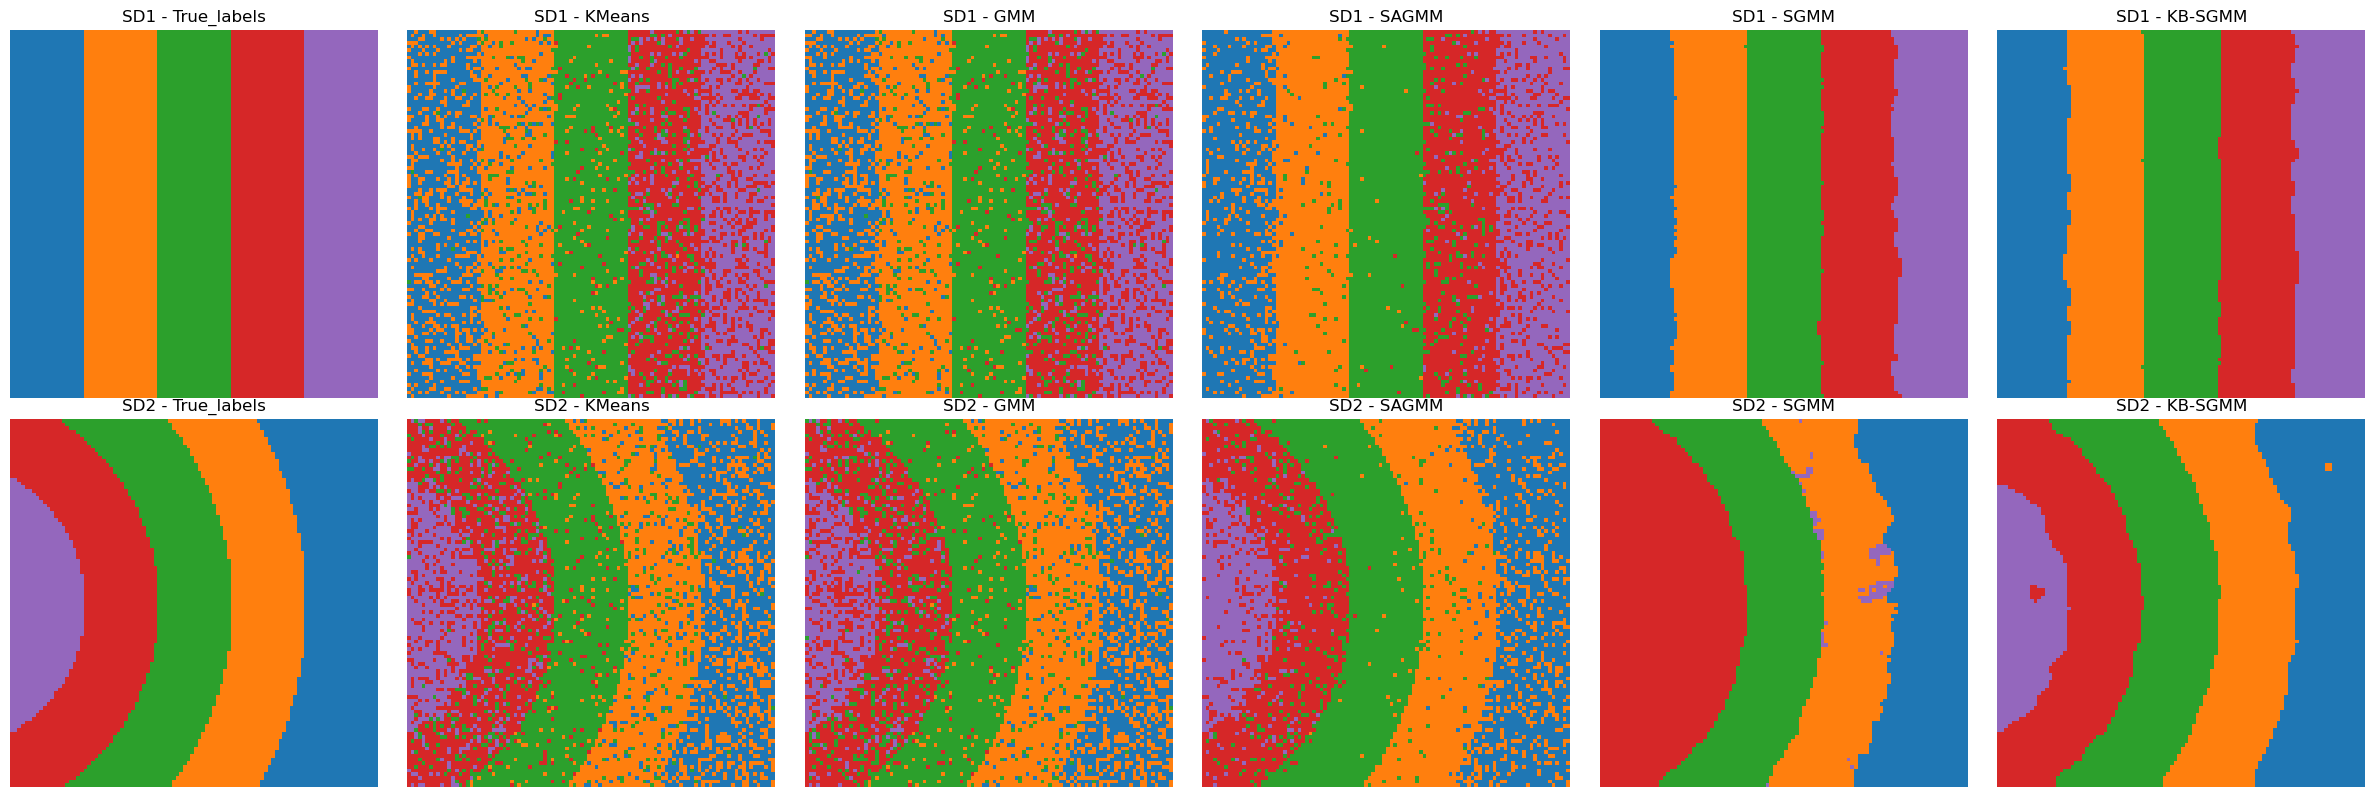

In [204]:
list_sd = [results1, results2]
plot_clustering_results_list("SD",list_sd, 100, 100, methods=None, cmap=cmap_tab5)

In [90]:
X1 = datasets_gds[0].reshape(-1,1)
gds_1,score_gds1,proba_gds1 = run_clustering_pipeline(X1,S1,label_matrices[0],n_clusters=5, window_size=7, lambda_=0.)

In [91]:
score_gds1

{'True_labels': {'ARI': 1.0, 'NMI': 1.0},
 'KMeans': {'ARI': 0.52, 'NMI': 0.6},
 'GMM': {'ARI': 0.53, 'NMI': 0.61},
 'SAGMM': {'ARI': 0.68, 'NMI': 0.74},
 'SGMM': {'ARI': 0.8, 'NMI': 0.84},
 'KB-SGMM': {'ARI': 0.92, 'NMI': 0.92}}

In [92]:
X1 = datasets_gds[1].reshape(-1,1)
gds_2,score_gds2, proba_gds2= run_clustering_pipeline(X1,S1,label_matrices[1],n_clusters=5, window_size=7, lambda_=0)

In [93]:
score_gds2

{'True_labels': {'ARI': 1.0, 'NMI': 1.0},
 'KMeans': {'ARI': 0.5, 'NMI': 0.6},
 'GMM': {'ARI': 0.52, 'NMI': 0.61},
 'SAGMM': {'ARI': 0.65, 'NMI': 0.73},
 'SGMM': {'ARI': 0.95, 'NMI': 0.93},
 'KB-SGMM': {'ARI': 0.92, 'NMI': 0.91}}

In [94]:
X1 = datasets_gds[2].reshape(-1,1)
gds_3,score_gds3,proba_gds3 = run_clustering_pipeline(X1,S1,label_matrices[2],n_clusters=5, window_size=7, lambda_=0)

In [95]:
score_gds3

{'True_labels': {'ARI': 1.0, 'NMI': 1.0},
 'KMeans': {'ARI': 0.43, 'NMI': 0.56},
 'GMM': {'ARI': 0.48, 'NMI': 0.59},
 'SAGMM': {'ARI': 0.48, 'NMI': 0.61},
 'SGMM': {'ARI': 0.77, 'NMI': 0.77},
 'KB-SGMM': {'ARI': 0.82, 'NMI': 0.81}}

In [96]:
X1 = datasets_gds[3].reshape(-1,1)
gds_4,score_gds4,proba_gds4 = run_clustering_pipeline(X1,S1,label_matrices[3],n_clusters=5, window_size=7, lambda_=0)

In [97]:
score_gds4

{'True_labels': {'ARI': 1.0, 'NMI': 1.0},
 'KMeans': {'ARI': 0.45, 'NMI': 0.55},
 'GMM': {'ARI': 0.54, 'NMI': 0.58},
 'SAGMM': {'ARI': 0.57, 'NMI': 0.63},
 'SGMM': {'ARI': 0.78, 'NMI': 0.78},
 'KB-SGMM': {'ARI': 0.87, 'NMI': 0.83}}

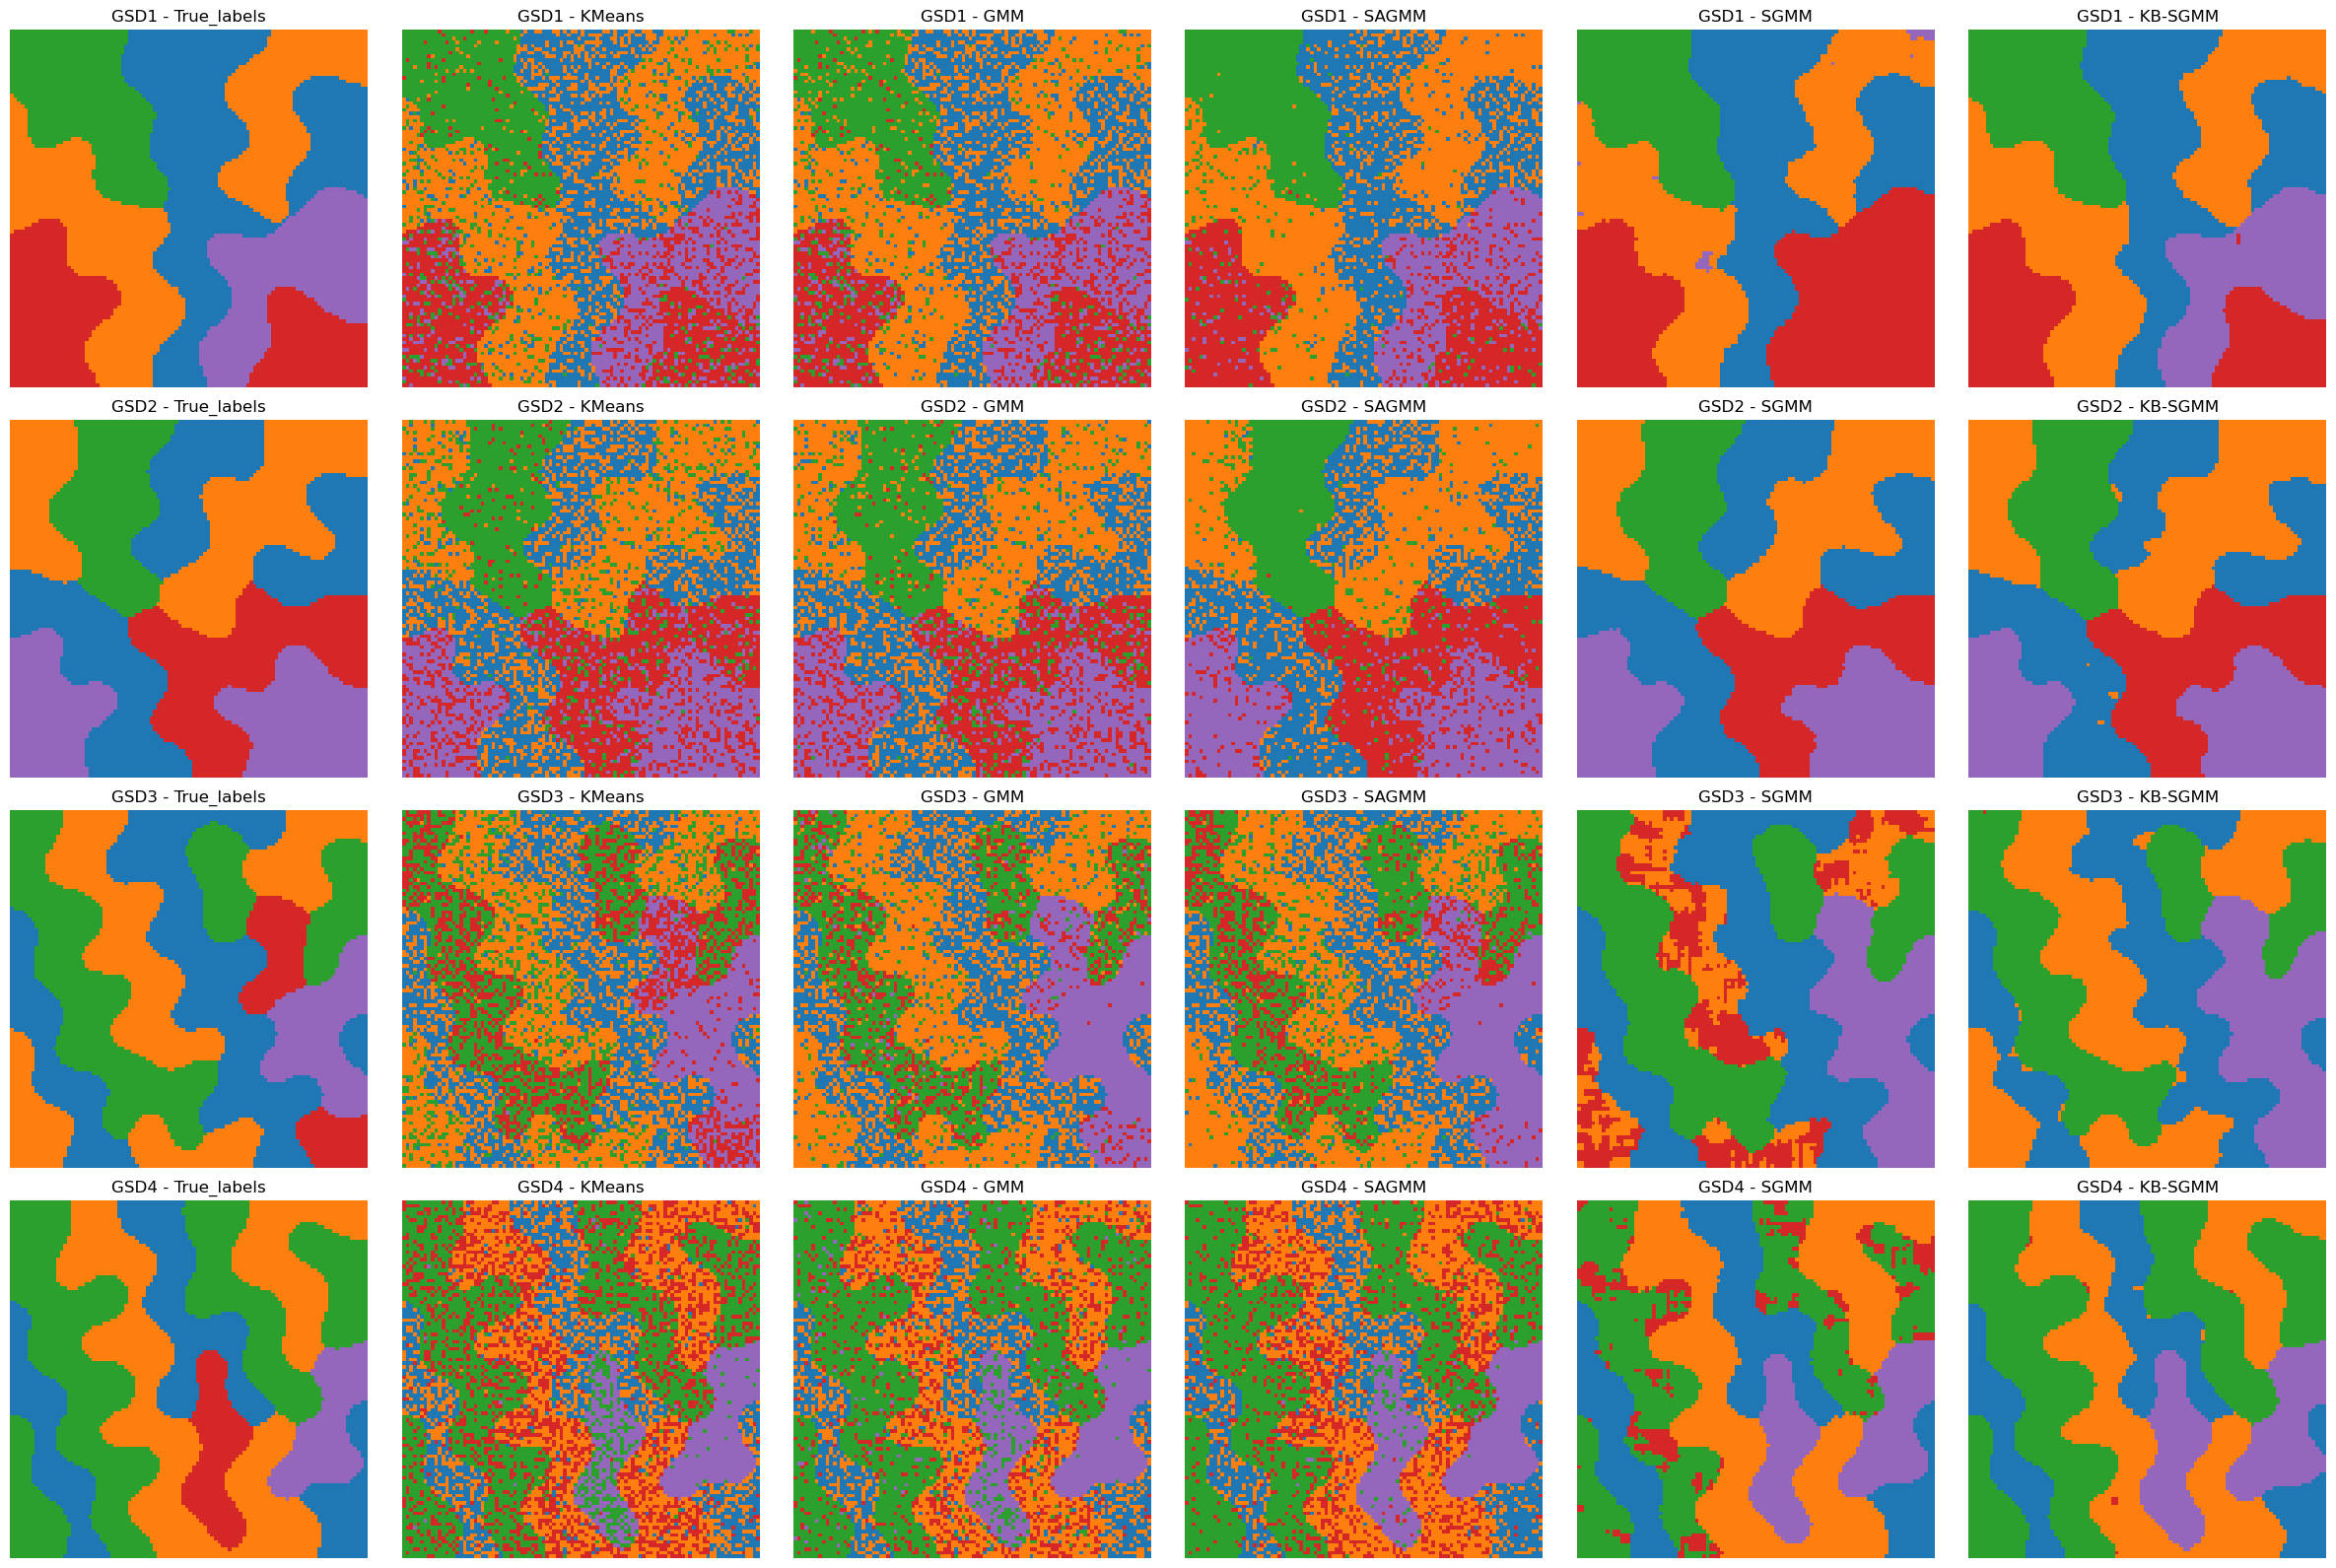

In [38]:
list_gds=[gds_1,gds_2,gds_3,gds_4]
plot_clustering_results_list('GSD',list_gds, 100, 100, methods=None, cmap=cmap_tab5)

In [121]:
p_all_sd = {
    "p_sd1": proba1,
    "p_sd2": proba2,
    "p_gsd1": proba_gds1,
    "p_gsd2": proba_gds2,
    "p_gsd3": proba_gds3,
    "p_gsd4": proba_gds4,
}

In [122]:
def compute_gds_errors(list_gds):
    gds_errors = {}

    for idx, result in enumerate(list_gds, start=1):
        true = result["True_labels"]
        errors = {}
        for method, pred in result.items():
            if method == "True_labels":
                continue
            # Erreur = 0 si identique, 1 sinon
            error = (pred != true).astype(int)
            errors[method] = error
        gds_errors[f"gds_error_{idx}"] = errors

    return gds_errors

In [126]:
gds_errors = compute_gds_errors(list_gds)
ds_errors = compute_gds_errors(list_sd)


In [124]:
with open("p_all_sd.pkl", "wb") as f:
    pickle.dump(p_all_sd, f)

In [125]:
with open("gds_errors.pkl", "wb") as f:
    pickle.dump(gds_errors, f)

In [128]:
with open("sd_errors.pkl", "wb") as f:
    pickle.dump(ds_errors, f)